# INF659-PUCP-2022-02 - Rayos X - Neumonía

## Preparación de datos
Competencia para el Curso de Técnicas Avanzadas de Data Mining y Sistemas Inteligentes 2022-02

- Alumno: Alipio Laboriano Galindo 



**Descripción**. Este desafío consiste en predecir que personas tienen neumonía. El dataset contiene imágenes de Rayos X del Tórax de pacientes que han sido diagnosticadas con neumonía severa y de pacientes que no han tenido neumonía severa después de un análisis por un médico experto. Por ello, se debe entrenar un modelo que tome como entrada una imagen de Rayos X del Tórax y determine si en la imagen hay o no neumonía.

Dataset (Fuente): https://europepmc.org/article/med/29474911


In [ ]:
# Cargar librerías
from google.colab import drive 

import pandas as pd
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm_notebook

import cv2
import matplotlib.pyplot as plt

## 1. Obtener datos

In [ ]:
# Configurar Google Drive como repositorio de trabajo.
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
## Establecer directorio de trabajo
%cd "/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia"

/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia


#### 1.1. Descargar id y etiquetas de la imágenes de Kaggle

In [ ]:
# Leer data del reto de Kaggle, id_imagen y clasificación
# más info en: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
! pip install kaggle
! mkdir ~/.kaggle
! cp /drive/MyDrive/Kaggle/keys/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Crear una carpeta con data, descargar  a esta carpeta, descomprimir la carpeta y eliminar el archivo zip.
!mkdir data
%cd /drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/data/
!kaggle competitions download -c inf659-pucp-2022-02-rayos-x-neumonia 
!unzip /drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/data/inf659-pucp-2022-02-rayos-x-neumonia.zip 
!rm /drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/data/inf659-pucp-2022-02-rayos-x-neumonia.zip 
%cd /drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/

/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/data
  0% 0.00/151k [00:00<?, ?B/s]
100% 151k/151k [00:00<00:00, 26.8MB/s]
Archive:  /drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/data/inf659-pucp-2022-02-rayos-x-neumonia.zip
  inflating: sample_submission.csv   
  inflating: test_x.csv              
  inflating: train.csv               
/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia


#### 1.2. Descargar imágenes del Dataset (Fuente): https://europepmc.org/article/med/29474911

In [ ]:
%%time
!git clone https://github.com/iapucp/X-Ray-Pneumonia-Images.git

Cloning into 'X-Ray-Pneumonia-Images'...
remote: Enumerating objects: 5828, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 5828 (delta 0), reused 2 (delta 0), pack-reused 5826
Receiving objects: 100% (5828/5828), 1.13 GiB | 13.34 MiB/s, done.
Checking out files: 100% (5856/5856), done.
CPU times: user 1.84 s, sys: 234 ms, total: 2.07 s
Wall time: 2min 36s


## 2. Explorar datos

In [ ]:
# Data con identificadores de ids y labels 
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test_x.csv')
df_send = pd.read_csv('./data/sample_submission.csv')
df_train.shape, df_test.shape, df_send.shape

((4977, 3), (879, 2), (879, 2))

- Hay 5,856 imágenes en total.
- 4,977 imágenes para entrenamiento y validación del modelo desarrollado.
- Para testeo hay 879 imágenes

In [ ]:
df_train.head()

,Id,File_names,Target
0,0,e184d851-45d7-50ff-85a9-9b75993484e7.jpeg,0
1,1,6e2c95c7-c0c2-565a-b3e2-d9de6eeb72ce.jpeg,1
2,2,2b7ca495-6101-5fe1-9c35-3a37e98a0cf2.jpeg,1
3,3,9d5fdc1a-22ac-5a4b-9942-694fa403765c.jpeg,1
4,4,786806b0-55cd-5aa3-a5d8-66701ffd77f7.jpeg,1


1    3632
0    1345
Name: Target, dtype: int64
1    0.729757
0    0.270243
Name: Target, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


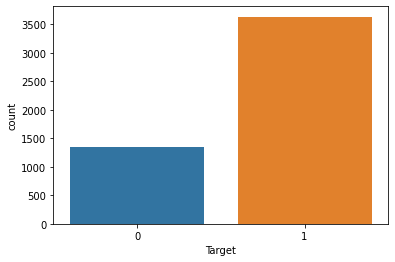

In [ ]:
# Verificar balanceo de datos.
print(df_train.Target.value_counts())
print(df_train.Target.value_counts()/df_train.shape[0])
sns.countplot(df_train.Target)

## 3. Construir la carpeta images con inputs de entrada

In [ ]:
# Crear carpeta images y dentro de ella dos subcarpetas para train  y tes
!mkdir images
!mkdir images/train
!mkdir images/test

!mkdir images/train/no_neumonia
!mkdir images/train/si_neumonia

!mkdir images/test/test_images

In [ ]:
# Copiar imagenes descargadas ya sea a la carpeta de train o test, dependiendo del dataset dónde se encuentran (Información dada en los csv´s).
# Directorio imágenes descargadas
path_images_dowload = '/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/X-Ray-Pneumonia-Images/Images/'
# Directorios train test
# Directorios nemonia si-no
path_images_train_si = '/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/images/train/si_neumonia'
path_images_train_no = '/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/images/train/no_neumonia'

path_images_test = '/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia/images/test/test_images'

for image in tqdm_notebook(os.listdir(path_images_dowload)):
    if image in df_train[df_train.Target==1].File_names.tolist():
        shutil.move(path_images_dowload + image, path_images_train_si)
    elif image in df_train[df_train.Target==0].File_names.tolist():
        shutil.move(path_images_dowload + image, path_images_train_no)
    else:
        shutil.move(path_images_dowload + image, path_images_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5856 [00:00<?, ?it/s]

In [ ]:
# Verificar cantidad de imgenes en train y test, debería haber 4,977 imágenes en train (1:3632 y 0:1345) y 879 en test
def numero_images_dir(path):
    initial_count = 0
    for path in pathlib.Path(path).iterdir():
        if path.is_file():
            initial_count += 1

    print('Hay {} imágenes'.format(initial_count))

In [ ]:
numero_images_dir(path_images_train_si)
numero_images_dir(path_images_train_no)
numero_images_dir(path_images_test)

Hay 3632 imágenes
Hay 1345 imágenes
Hay 879 imágenes


## 4. Visulaización de imágenes descargadas

0d9b9ed5-8adb-5b18-9285-55996cbf18c1.jpeg shape= (608, 1008, 3)


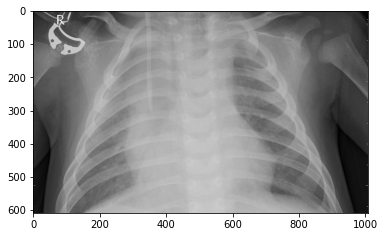

0ddb49ad-7ca0-5593-8010-49a68529eb83.jpeg shape= (704, 936, 3)


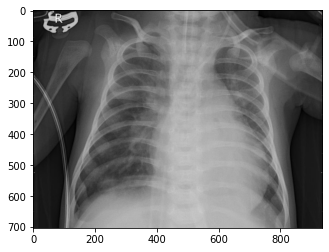

In [ ]:
# Pacientes si neumonia
for image in os.listdir(path_images_train_si)[200:202]:
    img = cv2.imread(path_images_train_si +'/'+ image)
    print(image, 'shape=', img.shape)
    plt.imshow(img)
    plt.show()

29913d2c-80ac-54cf-8fcf-b2fbeea6fad7.jpeg shape= (1936, 2252, 3)


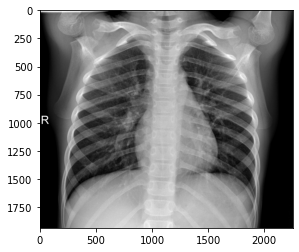

29a5ee84-c219-5fa8-8740-2c2a8bbf37d0.jpeg shape= (1125, 1422, 3)


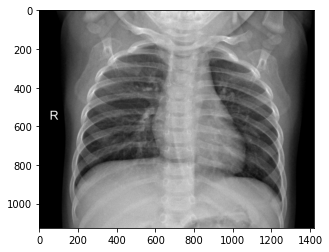

In [ ]:
# Pacientes no neumonia
for image in os.listdir(path_images_train_no)[200:202]:
    img = cv2.imread(path_images_train_no +'/'+ image)
    print(image, 'shape=', img.shape)
    plt.imshow(img)
    plt.show()